In [35]:
import nibabel as nib
from matplotlib import pyplot as plt
import skimage
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit

import seaborn as sns 
import glob
import statsmodels as sm

import pandas as pd
import re
import os
import glob
import shutil
import cv2
import xml.etree.ElementTree as ET
from scipy.spatial.distance import euclidean
import scipy.stats as st

%matplotlib inline

In [38]:
st.norm.pdf(0.9)

0.8159398746532405

In [191]:
base_seg = nib.load("/media/df3-dafna/Demo/113/brain_volume.nii").get_fdata()
slice_x, slice_y, slice_z = ndimage.find_objects(base_seg.astype(np.uint8))[0]
roi = base_seg[slice_x, slice_y,slice_z]
for elem in glob.glob("/media/df3-dafna/Demo/113/*.nii"):
    if 'body' in elem:
        continue
    elem_nii = nib.load(elem).get_fdata()
    elem_nii_roi = elem_nii[slice_x, slice_y,slice_z]
    elem_nii_new_fn = elem.replace(".nii", ".roi.nii")
    ni_img = nib.Nifti1Image(elem_nii_roi, np.eye(4))
    nib.save(ni_img, elem_nii_new_fn)

In [99]:
def plot_on(cur_ga, cur_value, total_mean, total_var, measure_name):
    ga = np.array(range(22*7,40*7,7))
    plt.plot(ga/7, total_mean, label=measure_name)
    plt.fill_between(ga/7, total_mean-total_var, total_mean+total_var, color='lightblue', alpha=.5, label='90% CI')
    plt.scatter(cur_ga, cur_value, marker='o', s=10, c='k')
    plt.title('normative '+measure_name+' vs GA')
    plt.xlabel('GA (weeks)')
    plt.ylabel(measure_name+' (mm)')
    plt.legend()
    return plt
    
    
def plot_on_cbd(cur_ga, cur_value):
    ga = np.array(range(22*7,40*7,7))
    bpd_mean = 221.6 - 2233.6 * (ga** -0.5)
    bpd_variance =  4.12  * 1.28
    return plot_on(cur_ga, cur_value, bpd_mean, bpd_variance, 'CBD')

def plot_on_bbd(cur_ga, cur_value):
    ga = np.array(range(22*7,40*7,7))
    bpd_mean =  142.7 - 14245.0 / ga 
    bpd_variance =  4.61 * 1.28
    return plot_on(cur_ga, cur_value, bpd_mean, bpd_variance, 'BBD')

def plot_on_tcd(cur_ga, cur_value):
    ga = np.array(range(22*7,40*7,7))
    tcd_mean = 8.09 + 2.32*(10**-5)*(ga ** 3) - 3.76*(10**-6)*(ga**3)*np.log(ga)
    tcd_variance =  1.06 * 1.28
    return plot_on(cur_ga, cur_value, tcd_mean, tcd_variance, 'TCD')
    

In [104]:
def plot_on_fetalweight(cur_ga, cur_value):
    ga = np.array(range(22,40,1))
    fw_mean = np.exp(0.578+0.332*ga-0.00354*(ga**2))
    fw_variance = 0.12 * 1.28 *fw_mean
    
    plt.plot(ga, fw_mean, label="FW")
    plt.fill_between(ga, fw_mean-fw_variance, fw_mean+fw_variance, color='lightblue', alpha=.5, label='90% CI')
    plt.scatter(cur_ga, cur_value, marker='o', s=10, c='k')
    plt.title('normative fetal weight (FW) vs GA')
    plt.xlabel('GA (weeks)')
    plt.ylabel('FW (mm^3)')
    plt.legend()
    return plt


In [145]:
def plot_on_brainvolume_dafi(cur_ga, cur_value):
    ga = np.array(range(18,40,1))
    bw_mean = np.exp( -0.38225508+  0.28012062*ga-0.0029532*(ga**2))
    bw_variance = 0.04 * 1.28 *bw_mean
    
    plt.plot(ga, bw_mean, label="BV")
    plt.fill_between(ga, bw_mean-bw_variance, bw_mean+bw_variance, color='lightblue', alpha=.5, label='90% CI')
    plt.scatter(cur_ga, cur_value, marker='o', s=10, c='k')
    plt.title('normative brain volume (BV) vs GA')
    plt.xlabel('GA (weeks)')
    plt.ylabel('BV (mm^3)')
    plt.legend()
    return plt

    
def plot_on_brainvolume_kyrk(cur_ga, cur_value):
    ga = np.array(range(22,38+1,1))
    bw_mean = -11.0802233484726 + -5.80680632639801 * ga + 0.376215489076761 * (ga**2)
    #bw_mean = np.exp((ga-22)*0.1304 + np.log(43.26)) #43.26*(1.131**(ga-22))
    #bw_variance = 0.2 * bw_mean
    bw_variance = 1.5899820908334 * ga + -32.1690253720697
    
    plt.plot(ga, bw_mean, label="BV")
    plt.fill_between(ga, bw_mean-bw_variance, bw_mean+bw_variance, color='lightblue', alpha=.5, label='90% CI')
    plt.scatter(cur_ga, cur_value, marker='o', s=10, c='k')
    plt.title('normative brain volume (BV) vs GA')
    plt.xlabel('GA (weeks)')
    plt.ylabel('BV (mm^3)')
    plt.legend()
    return plt



In [171]:
def plot_precentile(cur_mean, cur_var, cur_val, meas_name, meas_units="mm"):
    z = (cur_val - cur_mean) / cur_var
    percentile = st.norm.cdf(z) * 100
    v10 = cur_mean - cur_var*1.28
    v90 = cur_mean + cur_var*1.28
    
    fig, ax = plt.subplots(figsize=(5,1.5))
    plt.tight_layout()
    bpdict = ax.boxplot([v10,] + [cur_val,]*10 + [v90,] , vert=False)
    ax.annotate("10%", (v10, 0.8))
    ax.annotate("90%", (v90 - 0.5, 0.8))
    ax.annotate("{0:.0f}%".format(percentile), (bpdict['medians'][0].get_xdata()[0], 0.8))
    ax.set_title(meas_name)
    ax.set_xlabel("{}({})".format(meas_name,meas_units,))
    ax.plot([v10,v90],[1,1], c='lightblue')

    
def plot_cbd_prec(cur_ga, cur_val):
    ga = cur_ga * 7
    cbd_mean = 221.6 - 2233.6 * (ga** -0.5)
    cbd_variance =  4.12
    plot_precentile(cbd_mean, cbd_variance, cur_val, "CBD")
    
def plot_bbd_prec(cur_ga, cur_val):
    ga = cur_ga * 7
    bbd_mean =  142.7 - 14245.0 / ga 
    bbd_variance =  4.61
    plot_precentile(bbd_mean, bbd_variance, cur_val, "BBD")
    
def plot_tcd_prec(cur_ga, cur_val):
    ga = cur_ga * 7
    tcd_mean = 8.09 + 2.32*(10**-5)*(ga ** 3) - 3.76*(10**-6)*(ga**3)*np.log(ga)
    tcd_variance =  1.06 * 1.28
    plot_precentile(tcd_mean, tcd_variance, cur_val, "TCD")
    
def plot_fetalweight_prec(cur_ga, cur_val):
    fw_mean = np.exp(0.578+0.332*cur_ga-0.00354*(cur_ga**2))
    fw_variance = 0.12 * 1.28 *fw_mean
    plot_precentile(fw_mean, fw_variance, cur_val, "Fetal weight", "gram")

def plot_brainvolume_prec(cur_ga, cur_val):
    '''Kyrk'''
    bw_mean = -11.0802233484726 + -5.80680632639801 * cur_ga + 0.376215489076761 * (cur_ga**2)
    bw_variance = 1.5899820908334 * cur_ga + -32.1690253720697
    plot_precentile(bw_mean, bw_variance, cur_val, "Brain volume", "mL")

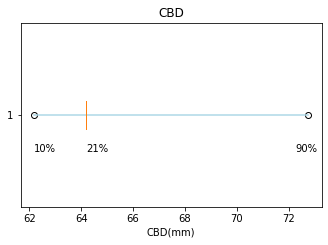

In [169]:
val = 64.2
ga = 30*7
bpd_mean = 221.6 - 2233.6 * (ga** -0.5)
bpd_variance =  4.12
plot_cbd_prec(30, 64.2)

In [112]:
val = 64.2
ga = 30*7
bpd_mean = 221.6 - 2233.6 * (ga** -0.5)
bpd_variance =  4.12
z = (val - bpd_mean) / bpd_variance
percentile = st.norm.cdf(z) * 100
v10 = bpd_mean - bpd_variance*1.28
v90 = bpd_mean + bpd_variance*1.28




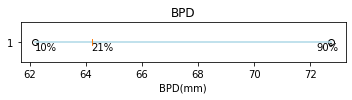

In [162]:
fig, ax = plt.subplots(figsize=(5,1.5))
bpdict = ax.boxplot([v10,] + [val,]*10 + [v90,] , vert=False)
ax.annotate("10%", (v10, 0.8))
ax.annotate("90%", (v90 - 0.5, 0.8))
ax.annotate("{0:.0f}%".format(percentile), (bpdict['medians'][0].get_xdata()[0], 0.8))
ax.set_title("BPD")
ax.set_xlabel("BPD(mm)")
ax.plot([v10,v90],[1,1], c='lightblue')
plt.tight_layout()

In [115]:
bpdict

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdb90d832e8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdb90fb0390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdb90d83940>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdb90ec4ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdb90ee7240>],
 'means': []}

### np.exp(0.1301*(30-22) + np.log(43.26))

In [155]:
plot_on_bbd(30, 64.2)

NameError: name 'plot_on_bbd' is not defined

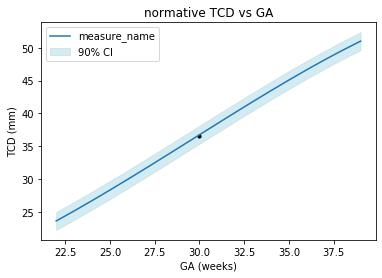

In [72]:
plot_on_tcd(30, 36.6)

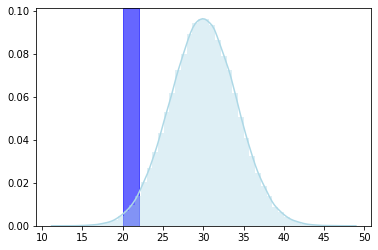

In [93]:
plt.axvspan(20, 22, color='b', alpha=.6)
sns.distplot(np.random.normal(30, 4.12, (1,200000)), color='lightblue')


In [27]:
bbd = [64.4,  67.3, 70.0, 72.5, 74.9, 77.0, 79.1, 81.0, 82.8 , 84.6, 86.2, 87.7, 89.1, 90.5, 91.8 ]
bbd_ga = np.arange(26,40+1)*7


In [36]:
tcd = [30.3, 31.8, 33.3, 35.0, 36.7 , 38.4, 40.1, 41.9, 43.6, 45.3, 46.9, 48.5, 49.9, 51.1, 52.2]
tcd_ga = np.arange(26,40+1)*7

In [129]:
bv = [40.572
,44.223
,48.131
,52.308
,56.763
,61.506
,66.547
,71.896
,77.56
,83.546
,89.862
,96.513
,103.503
,110.835
,118.512
,126.533
,134.898
,143.604
,152.646
,162.018
,171.711
,181.716
,192.02
,202.61
,213.467
,224.575
,235.912
,247.456
,259.182
,271.062
,283.069
,295.172
,307.338
,319.533
,331.722
,343.868
,355.933
,367.877
,379.661
,391.244
,402.586
,413.646
,424.382
,434.754
,444.723]
bv_log = np.log(bv)
bv_ga = np.arange(18,40+.5, .5)

In [37]:
def func(x, a, b):
    return a + b * (x** -0.5)


In [56]:
def func2(x, a, b,c):
    return a + b * (x** 3) + c *(x**3)*np.log(x) 

In [122]:
def func_bv(x, a, b, c):
    return a + b * (x) + c *(x**2)

In [130]:
popt, pcov = curve_fit(func_bv, bv_ga, bv_log)

In [132]:
popt, pcov

(array([-0.38225508,  0.28012062, -0.0029532 ]),
 array([[ 7.36420701e-11, -5.21640067e-12,  8.80809475e-14],
        [-5.21640067e-12,  3.74635297e-13, -6.39519495e-15],
        [ 8.80809475e-14, -6.39519495e-15,  1.10261982e-16]]))

In [59]:
tcd_ga / 7 

array([26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40.])

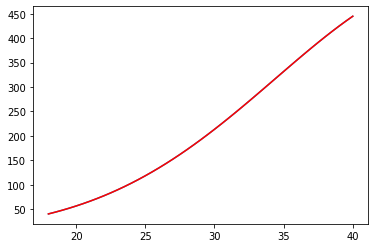

In [131]:
plt.plot(bv_ga, np.exp(func_bv(bv_ga, *popt)))
plt.plot(bv_ga, bv, 'r')

In [157]:
df_all = pd.read_excel("/cs/casmip/netana03/Demo/DemoBook.xlsx")

In [172]:
for i, l in df_all.iterrows():

    subj_id = int(l.Subject)
    if subj_id != 113:
        continue
    ga =  l["GA (Weeks)"]
    dir_out = os.path.join("/cs/casmip/netana03/Demo/", str(subj_id))
    plt.figure()
    plot_on_bbd(ga, l["BBD_Measure"])
    plt.savefig(os.path.join(dir_out, "bbd.png"), bbox_inches='tight')
    plt.figure()
    plot_on_cbd(ga, l["CBD_Measure"])
    plt.savefig(os.path.join(dir_out, "cbd.png"), bbox_inches='tight')
    plt.figure()
    plot_on_tcd(ga, l["TCD_Measure"])
    plt.savefig(os.path.join(dir_out, "tcd.png"), bbox_inches='tight')
    
    plt.figure()
    plot_on_fetalweight(ga, l["BodyVolume"])
    plt.savefig(os.path.join(dir_out, "bodyvolume.png"), bbox_inches='tight')
    
    plt.figure()
    plot_on_brainvolume_kyrk(ga, l["BrainVolume (mL)"])
    plt.savefig(os.path.join(dir_out, "brainvolume.png"), bbox_inches='tight')
    

NameError: name 'plot_on_bbd' is not defined

<Figure size 432x288 with 0 Axes>

/cs/labs/josko/netana03/work/env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/cs/labs/josko/netana03/work/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/cs/labs/josko/netana03/work/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

<Figure size 432x288 with 0 Axes>

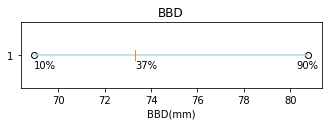

<Figure size 432x288 with 0 Axes>

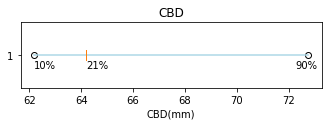

<Figure size 432x288 with 0 Axes>

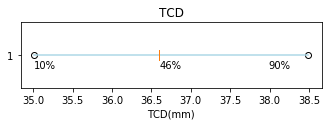

<Figure size 432x288 with 0 Axes>

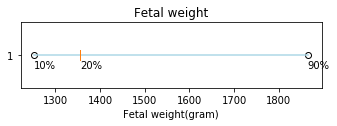

<Figure size 432x288 with 0 Axes>

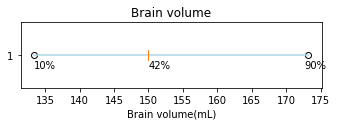

<Figure size 432x288 with 0 Axes>

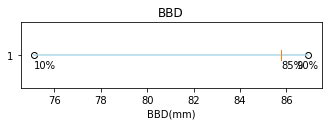

<Figure size 432x288 with 0 Axes>

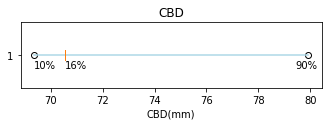

<Figure size 432x288 with 0 Axes>

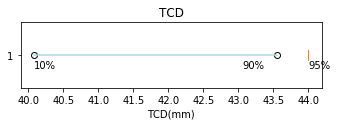

<Figure size 432x288 with 0 Axes>

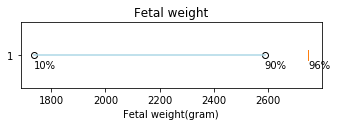

<Figure size 432x288 with 0 Axes>

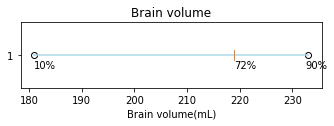

<Figure size 432x288 with 0 Axes>

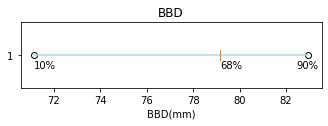

<Figure size 432x288 with 0 Axes>

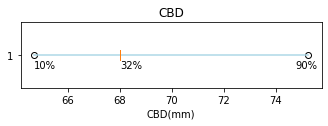

<Figure size 432x288 with 0 Axes>

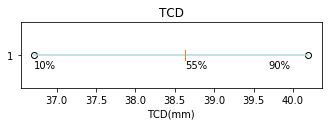

<Figure size 432x288 with 0 Axes>

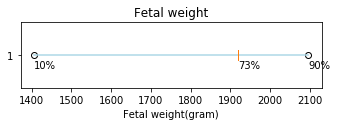

<Figure size 432x288 with 0 Axes>

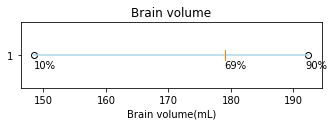

<Figure size 432x288 with 0 Axes>

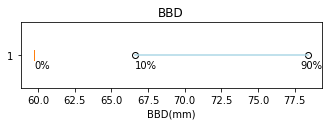

<Figure size 432x288 with 0 Axes>

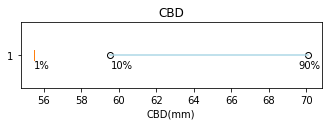

<Figure size 432x288 with 0 Axes>

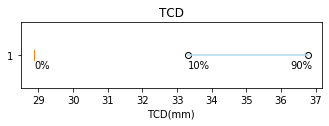

<Figure size 432x288 with 0 Axes>

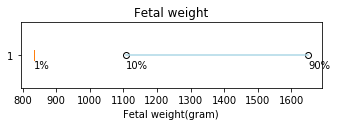

<Figure size 432x288 with 0 Axes>

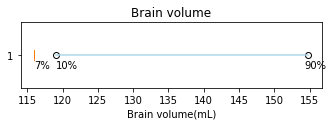

In [173]:
for i, l in df_all.iterrows():

    subj_id = int(l.Subject)
    ga =  l["GA (Weeks)"]
    dir_out = os.path.join("/cs/casmip/netana03/Demo/", str(subj_id))
    plt.figure()
    plot_bbd_prec(ga, l["BBD_Measure"])
    plt.savefig(os.path.join(dir_out, "bbd_prec.png"), bbox_inches='tight')
    plt.figure()
    plot_cbd_prec(ga, l["CBD_Measure"])
    plt.savefig(os.path.join(dir_out, "cbd_prec.png"), bbox_inches='tight')
    plt.figure()
    plot_tcd_prec(ga, l["TCD_Measure"])
    plt.savefig(os.path.join(dir_out, "tcd_prec.png"), bbox_inches='tight')
    
    plt.figure()
    plot_fetalweight_prec(ga, l["BodyVolume"])
    plt.savefig(os.path.join(dir_out, "bodyvolume_prec.png"), bbox_inches='tight')
    
    plt.figure()
    plot_brainvolume_prec(ga, l["BrainVolume (mL)"])
    plt.savefig(os.path.join(dir_out, "brainvolume_prec.png"), bbox_inches='tight')

In [186]:
brain_seg = nib.load("/media/df3-dafna/Demo/113/brain_volume.nii").get_fdata()
brain_vol = np.sum(brain_seg) * (0.7422 ** 2) * 5.0
brain_vol

115898.36643179998

In [187]:
body_seg = nib.load("/media/df3-dafna/Demo/113/body_volume.nii").get_fdata()
body_vol = np.sum(body_seg) * (1.5625 ** 2) * 4.0
body_vol

835820.3125

In [22]:
def parse_annotation(annot_file):
    tree = ET.parse(annot_file)
    root = tree.getroot()
    
    xy_res = float(annot_file.split("Res")[1].split("_")[0])
    
    measures = {}
    points = {}

    for elem in root.findall('folder'):
        if elem.attrib['key'] == 'Annotations':
            root = elem
    for elem in root.findall('folder'):
        pts = []
        color = ""
        for entry in elem.findall('entry'):
            if entry.attrib['key'] in ['Point1', 'Point2']:
                pts.append([float(a) for a in entry.attrib['value'].split(" ")])
            elif entry.attrib['key'] in ['Color',]:
                color = entry.attrib['value']
        pts_arr = np.array(pts)
        meas_len = euclidean(pts_arr[0], pts_arr[1])*xy_res
        #print(color, meas_len)
        if color == "1 0 0":
            measures['TCD'] = meas_len
            points['TCD'] = pts_arr
        else:
            if 'CBD' in measures.keys():
                if measures['CBD'] > meas_len:
                    measures['BBD'] = measures['CBD']
                    measures['CBD'] = meas_len
                    
                    points['BBD'] = points['CBD']
                    points['CBD'] = pts_arr
                else:
                    measures['BBD'] = meas_len
                    
                    points['BBD'] = pts_arr
            else:
                measures['CBD'] = meas_len 
                
                points['CBD'] = pts_arr
    return measures, points

In [188]:
dir_name = "/media/df3-dafna/Demo/113/"
measures_list = []
for annot in glob.glob(os.path.join(dir_name, "*.annot")):
    measures, points = parse_annotation(annot)
    if 'TCD' in points.keys():
        measures['TCD_Selection'] = int(points['TCD'][0,2] + .5)
        measures['Measure_TCD_X1'] = int(points['TCD'][0,0] + .5)
        measures['Measure_TCD_Y1'] = int(points['TCD'][0,1] + .5)
        measures['Measure_TCD_X2'] = int(points['TCD'][1,0] + .5)
        measures['Measure_TCD_Y2'] = int(points['TCD'][1,1] + .5)
    else:
        measures['TCD_Selection'] = None
    if 'BBD' in points.keys():
        measures['BBD_Selection'] = int(points['BBD'][0,2] + .5)
    else:
        measures['BBD_Selection'] = None
    measures_list.append(measures)
    print (measures)
    img = nib.load(os.path.join(dir_name, "brain.nii")).get_fdata()
    for p_type in points.keys():
        img_out = np.zeros_like(img)
        p_mat = points[p_type]
        plane_idx = int(p_mat[0,2] + .5)
        
        x1_point = int(p_mat[0,0] + .5)
        y1_point = int(p_mat[0,1] + .5)
        x2_point = int(p_mat[1,0] + .5)
        y2_point = int(p_mat[1,1] + .5)
        
        implane = np.zeros_like(img[:,:,plane_idx])
        im2show = implane.astype(np.float32)
        im2show = cv2.cvtColor(im2show, cv2.COLOR_GRAY2BGR)
        im2show = cv2.line(im2show, (y1_point,x1_point), (y2_point, x2_point), (255,255,255), 1)
        img_out[:,:,plane_idx] = im2show[:,:,1] > 1
        nib_out = nib.Nifti1Image(img_out, affine=np.eye(4))
        nib.save(nib_out, os.path.join(dir_name, p_type+".nii"))
df2 = pd.DataFrame(measures_list, columns=['TCD', 'CBD', 'BBD', 'TCD_Selection', 'BBD_Selection', 'Measure_TCD_X1', 'Measure_TCD_Y1', 'Measure_TCD_X2', 'Measure_TCD_Y2'])

{'TCD': 28.880413843144893, 'CBD': 55.49089828395685, 'BBD': 59.73854924873631, 'TCD_Selection': 13, 'Measure_TCD_X1': 269, 'Measure_TCD_Y1': 281, 'Measure_TCD_X2': 233, 'Measure_TCD_Y2': 267, 'BBD_Selection': 9}
